## Pair Programming A/B Testing

**Ejercicio 1:**

Supongamos que estamos realizando un experimento para determinar si un nuevo diseño de anuncio (test group "ad") tiene un impacto significativo en la tasa de conversión en comparación con el diseño de anuncio anterior (test group "psa").

- Objetivo del ejercicio: Comparar las tasas de conversión entre los grupos de prueba "ad" y "psa" para determinar si el nuevo diseño de anuncio es más efectivo en la conversión de usuarios.

- Pasos que debemos seguir:

    - Preparación de los datos: Asegúrate de que los datos estén limpios y listos para el análisis. Esto incluye la eliminación de datos faltantes y la verificación de la coherencia de los datos.

In [6]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats

pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.1f}'.format 

import warnings
warnings.filterwarnings("ignore")

In [7]:
df = pd.read_csv('marketing_AB.csv', index_col=0)
df.head(1)

,user id,test group,converted,total ads,most ads day,most ads hour
0,1069124,ad,False,130,Monday,20


In [8]:
# Hacemos una función para extraer la información del dataframe
def exploracion_dataframe(dataframe, columna_filtrado):
    
    print(f"Los duplicados que tenemos en el conjunto de datos son: {dataframe.duplicated().sum()}")
    print("\n ..................... \n")
    
    
    # Generamos un DataFrame para los valores nulos
    print("Los nulos que tenemos en el conjunto de datos son:")
    df_nulos = pd.DataFrame(dataframe.isnull().sum() / dataframe.shape[0] * 100, columns = ["%_nulos"])
    display(df_nulos[df_nulos["%_nulos"] > 0])
    
    print("\n ..................... \n")
    print(f"Los tipos de las columnas son:")
    display(pd.DataFrame(dataframe.dtypes, columns = ["tipo_dato"]))
    
    # Sacamos valores únicos de columnas categóricas
    print("\n ..................... \n")
    print("La cantidad de valores únicos que tenemos para las columnas categóricas son: ")
    dataframe_categoricas = dataframe.select_dtypes(include = "O")
    for col in dataframe_categoricas.columns:
        print(f"La columna {col.upper()} tiene los siguientes valores únicos:")
        display(pd.DataFrame(dataframe[col].value_counts()).head())    

    # Sacamos valores únicos de columnas numéricas
    print("\n ..................... \n")
    print("La cantidad de valores únicos que tenemos para las columnas numéricas son: ")
    dataframe_numericas = dataframe.select_dtypes(include = np.number)
    for col in dataframe_numericas.columns:
        print(f"La columna {col.upper()} tiene los siguientes valores únicos:")
        display(pd.DataFrame(dataframe[col].value_counts()).head()) 

    # Como estamos en un problema de A/B testing y lo que realmente nos importa es comparar entre el grupo de control y el de test, los principales estadísticos los vamos a sacar de cada una de las categorías
    for categoria in dataframe[columna_filtrado].unique():
        
        dataframe_filtrado = dataframe[dataframe[columna_filtrado] == categoria]
    
        print("\n ..................... \n")
        print(f"Los principales estadísticos de las columnas categóricas para el {categoria.upper()} son: ")
        display(dataframe_filtrado.describe(include = "O").T)
        
        print("\n ..................... \n")
        print(f"Los principales estadísticos de las columnas numéricas para el {categoria.upper()} son: ")
        display(dataframe_filtrado.describe().T)

In [9]:
exploracion_dataframe(df, 'test group')

Los duplicados que tenemos en el conjunto de datos son: 0

 ..................... 

Los nulos que tenemos en el conjunto de datos son:


,%_nulos



 ..................... 

Los tipos de las columnas son:


,tipo_dato
user id,int64
test group,object
converted,bool
total ads,int64
most ads day,object
most ads hour,int64



 ..................... 

La cantidad de valores únicos que tenemos para las columnas categóricas son: 
La columna TEST GROUP tiene los siguientes valores únicos:


,test group
ad,564577
psa,23524


La columna MOST ADS DAY tiene los siguientes valores únicos:


,most ads day
Friday,92608
Monday,87073
Sunday,85391
Thursday,82982
Saturday,81660



 ..................... 

La cantidad de valores únicos que tenemos para las columnas numéricas son: 
La columna USER ID tiene los siguientes valores únicos:


,user id
1069124,1
1116707,1
1275145,1
1338348,1
1352590,1


La columna TOTAL ADS tiene los siguientes valores únicos:


,total ads
1,56606
2,39827
5,29303
3,28661
4,23426


La columna MOST ADS HOUR tiene los siguientes valores únicos:


,most ads hour
13,47655
12,47298
11,46210
14,45648
15,44683



 ..................... 

Los principales estadísticos de las columnas categóricas para el AD son: 


,count,unique,top,freq
test group,564577,1,ad,564577
most ads day,564577,7,Friday,88805



 ..................... 

Los principales estadísticos de las columnas numéricas para el AD son: 


,count,mean,std,min,25%,50%,75%,max
user id,564577.0,1327314.3,188918.1,1000000.0,1163686.0,1327362.0,1490914.0,1654483.0
total ads,564577.0,24.8,43.8,1.0,4.0,13.0,27.0,2065.0
most ads hour,564577.0,14.5,4.8,0.0,11.0,14.0,18.0,23.0



 ..................... 

Los principales estadísticos de las columnas categóricas para el PSA son: 


,count,unique,top,freq
test group,23524,1,psa,23524
most ads day,23524,7,Thursday,3905



 ..................... 

Los principales estadísticos de las columnas numéricas para el PSA son: 


,count,mean,std,min,25%,50%,75%,max
user id,23524.0,911761.5,6790.9,900000.0,905880.8,911761.5,917642.2,923523.0
total ads,23524.0,24.8,42.9,1.0,4.0,12.0,26.0,907.0
most ads hour,23524.0,14.3,4.7,0.0,11.0,14.0,18.0,23.0


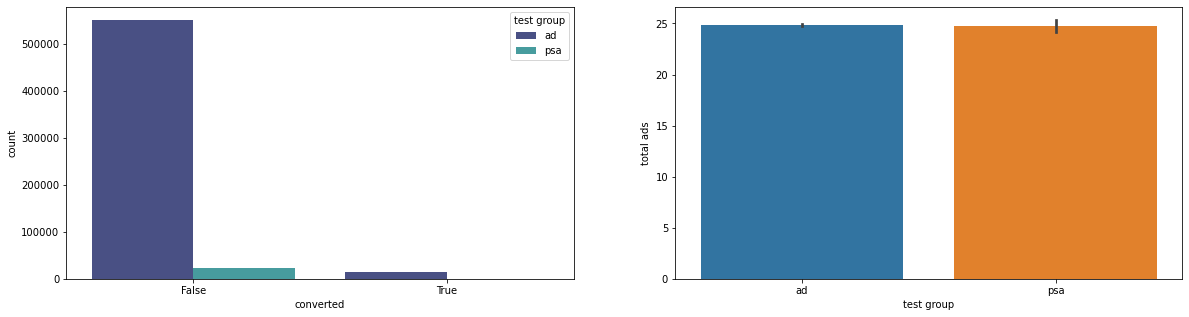

In [10]:
# Creamos el lienzo para nuestros gráficos, 1 fila, 2 columnas y el tamaño de la figura
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 5))

sns.countplot(hue = "test group",# para poder comparar ad y psa en el mismo gráfico, ponemos el parámetro 'hue', que nos traerá una columna para cada uno (ad, psa)
              x = "converted", # será True o False en función de si hubo conversión o no
              data = df,
              ax = axes[0],
              palette = "mako")

# Utilizamos un barplot para ver la proporción ads sobre id (ambos tienen un 100%)
sns.barplot(x = "test group", # para poder comparar ad y psa en el mismo gráfico, ponemos el parámetro 'hue', que nos traerá una columna para cada uno (ad, psa)
            y = "total ads", # trae la cantidad de ads de cada campaña
            data = df,
            ax = axes[1]);

- Definición de las hipótesis: Plantea una hipótesis nula (H0) y una hipótesis alternativa (H1) para el experimento (en este caso os las damos definidas):

    - Hipótesis nula (H0): No hay diferencia significativa en la tasa de conversión entre los grupos de prueba "ad" y "psa".

    - Hipótesis alternativa (H1): Existe una diferencia significativa en la tasa de conversión entre los grupos de prueba "ad" y "psa".

In [12]:
# Creamos una función para comprobar la normalidad e los datos
def normalidad(dataframe, columna):
    statistic, p_value = stats.shapiro(dataframe[columna])
    if p_value > 0.05:
        print(f"Para la columna {columna} los datos siguen una distribución normal.")
    else:
        print(f"Para la columna {columna} los datos no siguen una distribución normal.")

- Cálculo de la tasa de conversión: Calcula la tasa de conversión para cada grupo:

    - Para el grupo "ad", la tasa de conversión es el número de usuarios convertidos dividido por el número total de usuarios en ese grupo.

    - Para el grupo "psa", realiza el mismo cálculo.

- Prueba de hipótesis: Utiliza una prueba estadística, como la prueba t de Student o la prueba chi-cuadrado, para comparar las tasas de conversión entre los grupos "ad" y "psa".

- Análisis de resultados:

    - Si el valor p es menor que un umbral predefinido (por ejemplo, 0.05), rechazamos la hipótesis nula y concluimos que hay una diferencia significativa en las tasas de conversión entre los grupos.

    - Si el valor p es mayor que el umbral, no podemos rechazar la hipótesis nula y concluimos que no hay evidencia suficiente para afirmar que hay una diferencia significativa.

- Conclusiones y recomendaciones: Basándote en los resultados de la prueba de hipótesis, llega a una conclusión sobre si el nuevo diseño de anuncio es más efectivo en la conversión de usuarios que el diseño anterior. Si es así, puedes hacer recomendaciones basadas en estos hallazgos.

In [13]:
# Separamos los datos en dos grupos: "ad" y "psa"
group_ad = df[df['test group'] == 'ad']
group_psa = df[df['test group'] == 'psa']

# Calculamos las tasas de conversión para cada grupo
conversion_rate_ad = group_ad['converted'].mean()
conversion_rate_psa = group_psa['converted'].mean()

# Realizamos la prueba de hipótesis (prueba t de Student)
t_stat, p_value = stats.ttest_ind(group_ad['converted'], group_psa['converted'])

# Definimos un nivel de significancia (alfa)
alfa = 0.05

# Imprimimos los resultados
print(f"Tasa de conversión en el grupo 'ad': {conversion_rate_ad:.2f}")
print(f"Tasa de conversión en el grupo 'psa': {conversion_rate_psa:.2f}")
print(f"Valor p de la prueba de hipótesis: {p_value:.4f}")

# Comparamos el valor p con alfa para tomar una decisión
if p_value < alfa:
    print("Se rechaza la hipótesis nula: Hay una diferencia significativa en las tasas de conversión.")
else:
    print("No se rechaza la hipótesis nula: No hay evidencia suficiente para afirmar una diferencia significativa.")

Tasa de conversión en el grupo 'ad': 0.03
Tasa de conversión en el grupo 'psa': 0.02
Valor p de la prueba de hipótesis: 0.0000
Se rechaza la hipótesis nula: Hay una diferencia significativa en las tasas de conversión.


**Ejercicio 2:**

En este caso, vamos a realizar un experimento para comparar la cantidad promedio de anuncios vistos por los usuarios en los grupos "ad" y "psa" y determinar si hay una diferencia significativa entre ellos.

- Objetivo del experimento: Comparar la cantidad promedio de anuncios vistos por usuario entre los grupos de prueba "ad" y "psa" para determinar si el tipo de anuncio afecta la cantidad de anuncios que los usuarios ven.

- Preparación de los datos: Asegúrate de que los datos estén limpios y listos para el análisis. Esto incluye la eliminación de datos faltantes y la verificación de la coherencia de los datos.

In [14]:
df.head()

,user id,test group,converted,total ads,most ads day,most ads hour
0,1069124,ad,False,130,Monday,20
1,1119715,ad,False,93,Tuesday,22
2,1144181,ad,False,21,Tuesday,18
3,1435133,ad,False,355,Tuesday,10
4,1015700,ad,False,276,Friday,14


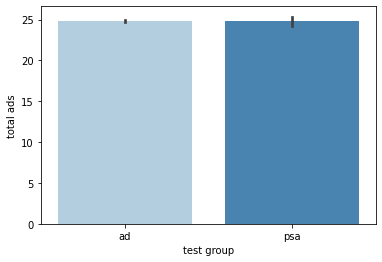

In [22]:
sns.barplot(x = "test group",
            y = "total ads",
            data = df,
            palette = "Blues");

- Hipótesis: Plantea una hipótesis nula (H0) y una hipótesis alternativa (H1) para el experimento. En este caso, las deberéis plantear vosotras

- Prueba de hipótesis: Utiliza una prueba estadística, como la prueba t de Student, para comparar la cantidad promedio de anuncios vistos por usuario entre los grupos "ad" y "psa". Esto te permitirá determinar si hay una diferencia significativa entre los dos grupos.

- Análisis de resultados:

    - Si el valor p (p-value) es menor que un umbral predefinido (por ejemplo, 0.05), rechazamos la hipótesis nula y concluimos que hay una diferencia significativa en la cantidad promedio de anuncios vistos por usuario entre los grupos.

    - Si el valor p es mayor que el umbral, no podemos rechazar la hipótesis nula y concluimos que no hay evidencia suficiente para afirmar que hay una diferencia significativa.

In [23]:
# Creamos una función para comprobar la normalidad de los datos
def normalidad(dataframe, columna):
    statistic, p_value = stats.shapiro(dataframe[columna])
    if p_value > 0.05:
        print(f"Para la columna {columna} los datos siguen una distribución normal.")
    else:
        print(f"Para la columna {columna} los datos no siguen una distribución normal.")

normalidad(df, "total ads")

Para la columna total ads los datos no siguen una distribución normal.


In [24]:
# Creamos una función para calcular este test y ver si hay diferencias entre los grupos de estudio
def test_man_whitney(dataframe, columnas_metricas, grupo_control, grupo_test, columna_grupos = "campaign_name"):
    
    # Filtramos el DataFrame para quedarnos sólo con los datos de control
    control = dataframe[dataframe[columna_grupos] == grupo_control]
    
    # Filtramos el DataFrame para quedarnos sólo con los datos de control
    test = dataframe[dataframe[columna_grupos] == grupo_test]
    
    # Iteramos por las columnas de las métricas para ver si para cada una de ellas hay diferencias entre los grupos
    for metrica in columnas_metricas:
        
        # Filtrams el conjunto de datos para quedarnos sólo con la columna de la métrica que nos interesa
        metrica_control = control[metrica]
        metrica_test = test[metrica]
        
        # Aplicamos el estadístico
        u_statistic, p_value = stats.mannwhitneyu(metrica_control, metrica_test)
        
        if p_value < 0.05:
            print(f"Para la métrica {metrica}, las medianas son diferentes.")
        else:
            print(f"Para la métrica {metrica}, las medianas son iguales.")
            
test_man_whitney(df, ["total ads"], "ad", "psa", columna_grupos="test group" )

Para la métrica total ads, las medianas son diferentes.


- Conclusiones y recomendaciones: Basándote en los resultados de la prueba de hipótesis, llega a una conclusión sobre si el tipo de anuncio (ad o psa) tiene un impacto significativo en la cantidad promedio de anuncios vistos por usuario. Si es así, puedes hacer recomendaciones basadas en estos hallazgos.

**Hipótesis nula (H0)**: No hay diferencia significativa en la cantidad promedio de anuncios vistos por usuario entre los grupos "ad" y "psa".

**Hipótesis alternativa (H1)**: Existe una diferencia significativa en la cantidad promedio de anuncios vistos por usuario entre los grupos "ad" y "psa".